# Staggered Grids

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import kernex as kex
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from jaxtyping import Array
import einops
import finitediffx as fdx
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.functional import cgrid as C_grid
from jaxsw._src.boundaries import functional as F_bc
from jaxsw._src.domain.base import Domain


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1-Dimensional

```python
+ -- ⋅ -- +
u -- u̅ -- u
+ -- ⋅ -- +
```


```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx"] = ...
```

In [2]:
ncols = 5

# initialize the Q domain
q_domain = Domain(xmin=(0,), xmax=(ncols + 1,), dx=(1,))

# initialize the u-velocity domain
u_domain = Domain(xmin=(0.5,), xmax=(ncols + 0.5,), dx=(1,))


# extract grid values
q_field = q_domain.grid.squeeze()
u_field = u_domain.grid.squeeze()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


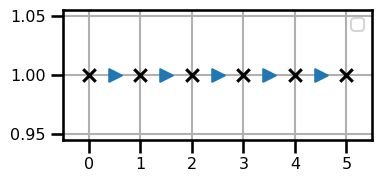

In [3]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q_field, jnp.ones_like(q_field), marker="x", color="black", zorder=2)
ax.scatter(u_field, jnp.ones_like(u_field), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

### Edges to Nodes

This happens when we want to move the field on the top-down edges to the nodes.
For example, we may want to use the velocities to for some quantity defined at the nodes.

In [4]:
# Edge --> Node
u_on_q = C_grid.edge_to_node_1D(u_field)

# check array is equal
np.testing.assert_array_equal(u_on_q, q_field[1:-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


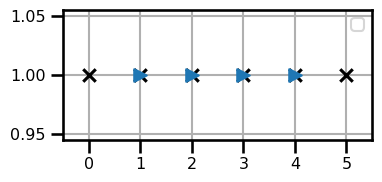

In [5]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q_field, jnp.ones_like(q_field), marker="x", color="black", zorder=2)
ax.scatter(u_on_q, np.ones_like(u_on_q), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

### Nodes to Edges

This happens when we want to move the field defined on the field to the top-down edges.
For example, we may want to use the quantity of interest defined on the nodes to estimate the velocities defined on the top-down edges.

```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx-1"] = ...
```

In [6]:
# Edge --> Node
q_on_u = C_grid.node_to_edge_1D(q_field)

# check array is equal
np.testing.assert_array_equal(q_on_u, u_field)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


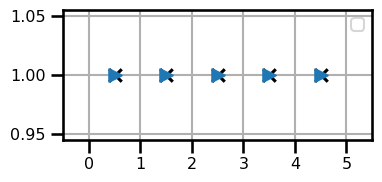

In [7]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q_on_u, np.ones_like(q_on_u), marker="x", color="black", zorder=2)
ax.scatter(u_field, np.ones_like(u_field), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

## Arakawa C-Grid

In this example, we will look at the classic Arakawa C-Grid.
This seems to be the standard for using standard finite difference methods on gridded domains.
All of the variables are on staggered domains which means that we will have to do some small transformations to put each variable on other domains.

In this example, we'll look at two variables along with their corresponding velocities.
The inspiration comes from the QG equation where we have

$$
\begin{aligned}
\partial_t q + \vec{u}\cdot q &= 0 \\
q = \boldsymbol{\nabla}_H \psi
\end{aligned}
$$

where we have four variables we need to handle in total:

* $q$ - potential vorticity on the cell faces
* $u$ - zonal velocity on the Top-Bottom cell edges
* $v$ - meridional velocity on the East-West cell edges
* $\psi$ - stream function on the cell nodes.

In [8]:
n_rows = 3
n_cols = 5

# cell corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows + 1, n_cols + 1), dx=(1, 1))

# cell faces
q_domain = Domain(xmin=(0.5, 0.5), xmax=(n_rows + 0.5, n_cols + 0.5), dx=(1, 1))

# U Velocity
u_domain = Domain(xmin=(0.5, 0), xmax=(n_rows + 0.5, n_cols + 1), dx=(1, 1))

# V Velocity
v_domain = Domain(xmin=(0, 0.5), xmax=(n_rows + 1, n_cols + 0.5), dx=(1, 1))

print(psi_domain.size, q_domain.size, u_domain.size, v_domain.size)

# extract the field values
psi_field = psi_domain.grid
q_field = q_domain.grid
u_field = u_domain.grid
v_field = v_domain.grid

(4, 6) (3, 5) (3, 6) (4, 5)


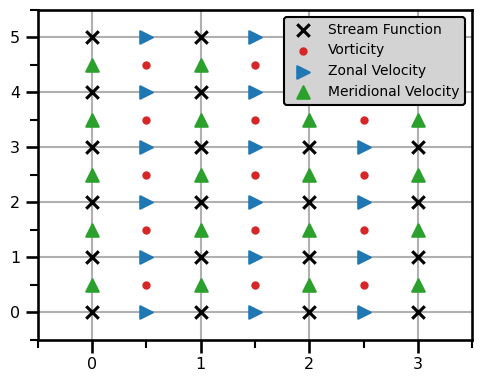

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_domain.grid[..., 0].ravel(),
    psi_domain.grid[..., 1].ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_domain.grid[..., 0].ravel(),
    q_domain.grid[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=2,
    label="Vorticity",
)
ax.scatter(
    u_domain.grid[..., 0].ravel(),
    u_domain.grid[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_domain.grid[..., 0].ravel(),
    v_domain.grid[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

This example seems quite complicated and possibly unnecessary because we have two variables and the velocities.
This can occur in the contrived example but in many cases, we may only have 1 variable and the velocities, e.g. Shallow Water equations.
In this case, we have some options, we can use the cell faces as the main variable or the cell nodes.
It's up to us. 

### Transformations to Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
\psi &\rightarrow q \\
u &\rightarrow q \\
v &\rightarrow q
\end{aligned}
$$

In [10]:
# u velocities
u_on_q_x = C_grid.edge_tb_to_face_2D(u_field[..., 0])
u_on_q_y = C_grid.edge_tb_to_face_2D(u_field[..., 1])

# v velocities
v_on_q_x = C_grid.edge_lr_to_face_2D(v_field[..., 0])
v_on_q_y = C_grid.edge_lr_to_face_2D(v_field[..., 1])

# psi variable
psi_on_q_x = C_grid.node_to_face_2D(psi_field[..., 0])
psi_on_q_y = C_grid.node_to_face_2D(psi_field[..., 1])

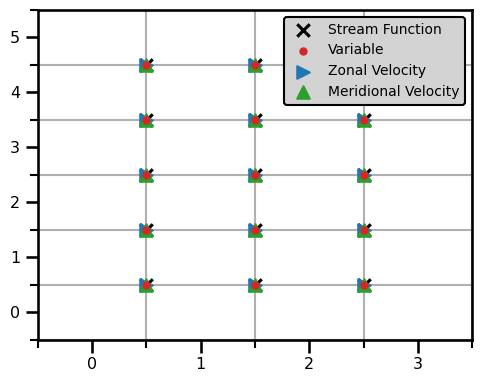

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))


ax.scatter(
    psi_on_q_x.ravel(),
    psi_on_q_y.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)

ax.scatter(
    q_field[..., 0].ravel(),
    q_field[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_on_q_x.ravel(),
    u_on_q_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_q_x.ravel(),
    v_on_q_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to PSI Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow \psi \\
u &\rightarrow \psi \\
v &\rightarrow \psi
\end{aligned}
$$

In [12]:
# u velocities
u_on_psi_x = C_grid.edge_tb_to_node_2D(u_field[..., 0])
u_on_psi_y = C_grid.edge_tb_to_node_2D(u_field[..., 1])

# v velocities
v_on_psi_x = C_grid.edge_lr_to_node_2D(v_field[..., 0])
v_on_psi_y = C_grid.edge_lr_to_node_2D(v_field[..., 1])

# psi variable
q_on_psi_x = C_grid.face_to_node_2D(q_field[..., 0])
q_on_psi_y = C_grid.face_to_node_2D(q_field[..., 1])

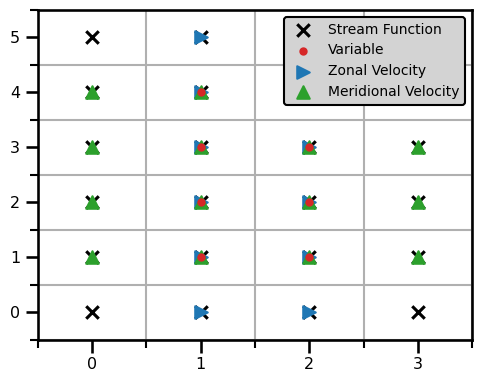

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))


ax.scatter(
    psi_field[..., 0].ravel(),
    psi_field[..., 1].ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)

ax.scatter(
    q_on_psi_x.ravel(),
    q_on_psi_y.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_on_psi_x.ravel(),
    u_on_psi_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_psi_x.ravel(),
    v_on_psi_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to U-Velocity

In this first case, we will look at all transformations that can get us to the u-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow u \\
\psi &\rightarrow u \\
v &\rightarrow u
\end{aligned}
$$

In [14]:
# V Velocities
v_on_u_x = C_grid.edge_lr_to_edge_tb_2D(v_field[..., 0])
v_on_u_y = C_grid.edge_lr_to_edge_tb_2D(v_field[..., 1])

# Q Variable
psi_on_u_x = C_grid.node_to_edge_tb_2D(psi_field[..., 0])
psi_on_u_y = C_grid.node_to_edge_tb_2D(psi_field[..., 1])

# psi variable
q_on_u_x = C_grid.face_to_edge_tb_2D(q_field[..., 0])
q_on_u_y = C_grid.face_to_edge_tb_2D(q_field[..., 1])

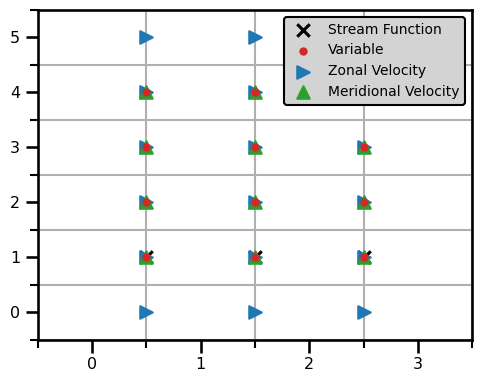

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))


ax.scatter(
    psi_on_u_x[..., 0].ravel(),
    psi_on_u_y[..., 1].ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)

ax.scatter(
    q_on_u_x.ravel(),
    q_on_u_y.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_field[..., 0].ravel(),
    u_field[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_u_x.ravel(),
    v_on_u_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to V-Velocity

In this first case, we will look at all transformations that can get us to the v-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow v \\
\psi &\rightarrow v \\
u &\rightarrow v
\end{aligned}
$$

In [16]:
# U Velocities
u_on_v_x = C_grid.edge_tb_to_edge_lr(u_field[..., 0])
u_on_v_y = C_grid.edge_tb_to_edge_lr(u_field[..., 1])

# Q Variable
psi_on_v_x = C_grid.node_to_edge_lr_2D(psi_field[..., 0])
psi_on_v_y = C_grid.node_to_edge_lr_2D(psi_field[..., 1])

# psi variable
q_on_v_x = C_grid.face_to_edge_lr_2D(q_field[..., 0])
q_on_v_y = C_grid.face_to_edge_lr_2D(q_field[..., 1])

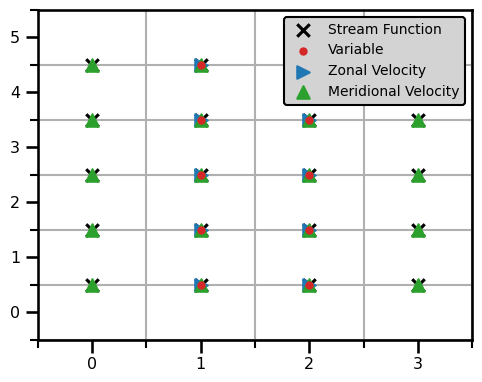

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))


ax.scatter(
    psi_on_v_x.ravel(),
    psi_on_v_y.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)

ax.scatter(
    q_on_v_x.ravel(),
    q_on_v_y.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_on_v_x.ravel(),
    u_on_v_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_field[..., 0].ravel(),
    v_field[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()